In [1]:
# %pip install dandi
# %pip install fsspec requests aiohttp


In [2]:
from dandi.dandiapi import DandiAPIClient

dandiset_id = '000402'  # ophys dataset from the Tolias Lab
filepath = 'sub-17797/sub-17797_ses-4-scan-7_behavior+image+ophys.nwb'  # 71 GB file
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

In [3]:
import fsspec
import pynwb
import h5py
from fsspec.implementations.cached import CachingFileSystem

In [5]:
# first, create a virtual filesystem based on the http protocol
fs = fsspec.filesystem('http')

In [7]:
# create a cache to save downloaded data to disk (optional)
fs = CachingFileSystem(
    fs=fs,
    cache_storage='nwb-cache',  # Local folder for the cache
)

In [32]:
nwbfile

root pynwb.file.NWBFile at 0x139870296354048
Fields:
  acquisition: {
    EyeTracking <class 'pynwb.behavior.EyeTracking'>,
    PupilTracking <class 'pynwb.behavior.PupilTracking'>,
    TwoPhotonSeries1 <class 'pynwb.ophys.TwoPhotonSeries'>,
    TwoPhotonSeries2 <class 'pynwb.ophys.TwoPhotonSeries'>,
    TwoPhotonSeries3 <class 'pynwb.ophys.TwoPhotonSeries'>,
    TwoPhotonSeries4 <class 'pynwb.ophys.TwoPhotonSeries'>,
    TwoPhotonSeries5 <class 'pynwb.ophys.TwoPhotonSeries'>,
    TwoPhotonSeries6 <class 'pynwb.ophys.TwoPhotonSeries'>,
    TwoPhotonSeries7 <class 'pynwb.ophys.TwoPhotonSeries'>,
    TwoPhotonSeries8 <class 'pynwb.ophys.TwoPhotonSeries'>,
    Video: stimulus_17797_4_7_v4 <class 'pynwb.image.ImageSeries'>,
    treadmill_velocity <class 'pynwb.base.TimeSeries'>
  }
  devices: {
    Microscope <class 'pynwb.device.Device'>
  }
  experiment_description: The light microscopic images were acquired from a cubic millimeter volume that spanned portions of primary visual cortex and three higher visual cortical areas. The volume was imaged in vivo by two-photon random access mesoscope (2P-RAM) from postnatal days P75 to P81 in a male mouse expressing a genetically encoded calcium indicator in excitatory cells, while the mouse viewed natural movies and parametric stimuli. The calcium imaging data includes the single-cell responses of an estimated 75,000 pyramidal cells imaged over a volume of approximately 1200 x 1100 x 500 μm3 (anteroposterior x mediolateral x radial depth). The center of the volume was placed at the junction of primary visual cortex (VISp) and three higher visual areas, lateromedial area (VISlm), rostrolateral area (VISrl) and anterolateral area (VISal). During imaging, the animal was head-restrained, and the stimulus was presented to the left visual field. Treadmill rotation (single axis) and video of the animal's left eye were captured throughout the scan, yielding the locomotion velocity, eye movements, and pupil diameter data included here. The functional data were co-registered with electron microscopy (EM) data. The structural identifiers of the matched cells are added as plane segmentation columns extracted from the CAVE database. To access the latest revision see the notebook that is linked to this dandiset. The structural ids might not be present for all plane segmentations.
  file_create_date: [datetime.datetime(2023, 2, 12, 21, 42, 50, 495563, tzinfo=tzlocal())]
  identifier: c6513d28-a8a2-454a-80ca-8440f23fdd64
  imaging_planes: {
    ImagingPlane1 <class 'pynwb.ophys.ImagingPlane'>,
    ImagingPlane2 <class 'pynwb.ophys.ImagingPlane'>,
    ImagingPlane3 <class 'pynwb.ophys.ImagingPlane'>,
    ImagingPlane4 <class 'pynwb.ophys.ImagingPlane'>,
    ImagingPlane5 <class 'pynwb.ophys.ImagingPlane'>,
    ImagingPlane6 <class 'pynwb.ophys.ImagingPlane'>,
    ImagingPlane7 <class 'pynwb.ophys.ImagingPlane'>,
    ImagingPlane8 <class 'pynwb.ophys.ImagingPlane'>
  }
  intervals: {
    Clip <class 'pynwb.epoch.TimeIntervals'>,
    Monet2 <class 'pynwb.epoch.TimeIntervals'>,
    Trippy <class 'pynwb.epoch.TimeIntervals'>
  }
  processing: {
    ophys <class 'pynwb.base.ProcessingModule'>
  }
  related_publications: ['https://doi.org/10.1101/2021.07.28.454025']
  session_description: Contains calcium imaging recorded from multiple cortical visual areas and behavioral measurements while a mouse viewed natural movies and parametric stimuli. The structural ids are added as plane segmentation columns from the CAVE database on 2023-02-12. To access the latest revision see the notebook that is linked to the dandiset. The structural ids might not be present for all plane segmentations.
  session_id: 4-scan-7
  session_start_time: 2018-03-04 00:00:00+00:00
  subject: subject pynwb.file.Subject at 0x139870294334336
Fields:
  age: P75D/P81D
  sex: M
  species: Mus musculus
  subject_id: 17797

  timestamps_reference_time: 2018-03-04 00:00:00+00:00

In [35]:
# next, open the file
with fs.open(s3_url, 'rb') as f:
    with h5py.File(f) as file:
        with pynwb.NWBHDF5IO(file=file, load_namespaces=True) as io:
            nwbfile = io.read()
            pupil_timestamps = nwbfile.acquisition['PupilTracking'].time_series['pupil_minor_radius'].timestamps[:]
            pupil_major_radius = nwbfile.acquisition['PupilTracking'].time_series['pupil_minor_radius'].data[:]
            pupil_eye_positions = nwbfile.acquisition['EyeTracking'].spatial_series['eye_position'].data[:]
            treadmill_velocities = nwbfile.acquisition['treadmill_velocity'].data[:]
            treadmill_times = nwbfile.acquisition['treadmill_velocity'].timestamps[:]
            twop_acquisition_frames = nwbfile.acquisition['TwoPhotonSeries1'].data[:500,:500,:500]
            twop_acquisition_times = nwbfile.acquisition['TwoPhotonSeries1'].timestamps[:500]
        



In [37]:
nwbfile.intervals['Clip'].columns[:]

(<hdmf.common.table.VectorData at 0x7f360c19f640>,
 <hdmf.common.table.VectorData at 0x7f360c132eb0>)

In [36]:
np.shape(twop_acquisition_frames)

(500, 248, 440)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
np.shape(twop_acquisition_)

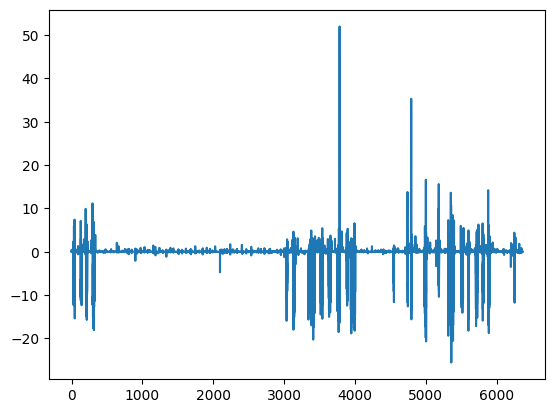

In [31]:
plt.plot(treadmill_times,treadmill_velocities)

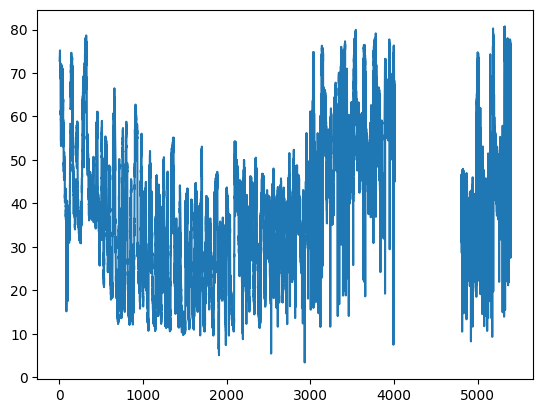

In [18]:
plt.plot(pupil_timestamps,pupil_major_radius)

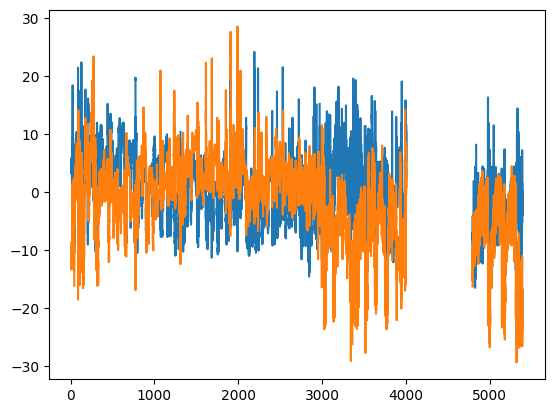

In [26]:
plt.plot(pupil_timestamps,pupil_eye_positions - np.nanmedian(pupil_eye_positions,axis=0,keepdims=True))



In [ ]:
#TODO:
#move pip install to dockerfile
#visualize behavioral state chagnes (pupil size, treadmill)
#visualize pupil location changes (pupil x/y)
#visualize clip from motion and raster corrected movies
#visualize average images and segmentation
#visualize fluorescence and activity
#visualize oracle raster
#visualize monet raster

